## **About the FYP**

### Age & Gender Prediction from Facial Images: A Bias-Aware Deep Learning Approach for Personalized User Experiences

Age and gender prediction from facial images is widely used in areas such as personalized marketing, security, and healthcare. However, current models suffer from:

**Bias in datasets:** Most datasets are dominated by certain demographics, leading to unfair predictions.

**Inaccuracies in real-world applications:** Deep learning models struggle with varying lighting, angles, and ethnic diversity.

**Limited generalization:** Models often perform well on benchmark datasets but fail in real-world scenarios.

### Installing Relevant Libraries

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is NOT available.")


GPU is NOT available.


In [2]:
!pip install polars

In [3]:
!pip install torchviz


In [4]:
!pip install torch torchvision

In [5]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (29 kB)
Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp312-cp312-win_amd64.whl (4.1 MB)
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ----------------------------------

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\MahwishMalik\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\MahwishMalik\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\MahwishMalik\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\MahwishMalik\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MahwishMalik\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\MahwishMalik\anaconda3\Lib\socket.py", line 720, in readinto
    r

In [6]:
!python -m ipykernel install --user --name torch_env --display-name "Python (torch_env)"

Installed kernelspec torch_env in C:\Users\MahwishMalik\AppData\Roaming\jupyter\kernels\torch_env


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [7]:
!pip install streamlit

### 1. Importing Libraries

In [32]:
import os
import re
import time
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from PIL import Image
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18, ResNet18_Weights
from collections import defaultdict, Counter
import zipfile
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import VGG16_Weights
from torchvision.models import Inception_V3_Weights
import numpy as np
import torch.nn as nn

### 2. Configuration & Hyperparameters

In [4]:
data_dir = r"C:\Users\MahwishMalik\Downloads\Dataset-Images"
batch_size = 32
epochs = 10
learning_rate = 0.001
image_size = (224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Display each value
print("Data Directory:", data_dir)
print("Batch Size:", batch_size)
print("Epochs:", epochs)
print("Learning Rate:", learning_rate)
print("Image Size:", image_size)
print("Device:", device)

Data Directory: C:\Users\MahwishMalik\Downloads\Dataset-Images
Batch Size: 32
Epochs: 10
Learning Rate: 0.001
Image Size: (224, 224)
Device: cpu


In [6]:
import torch
print(torch.__version__)

2.7.0+cpu


In [7]:
import os

folder_path = r"C:\Users\MahwishMalik\Downloads\Images-Dataset"

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg.jpg"):
        os.rename(os.path.join(folder_path, filename), 
                  os.path.join(folder_path, filename.replace(".jpg.jpg", ".jpg")))
    elif filename.endswith(".jpeg.jpeg"):
        os.rename(os.path.join(folder_path, filename), 
                  os.path.join(folder_path, filename.replace(".jpeg.jpeg", ".jpeg")))


### 3. Custom Dataset Class

In [33]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# Define age brackets (labels)
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

# Complete Age Range Mapping including all variations
age_mapping = {
    '0-9': '0-9',
    '0-10': '0-9',
    '10-19': '10-19',
    '11-19': '10-19',
    '11-20': '10-19',  
    '20-29': '20-29',
    '21-30': '20-29',
    '30-39': '30-39',
    '31-40': '30-39',
    '40-49': '40-49',
    '41-50': '40-49',
    '50-59': '50-59',
    '51-60': '50-59',
    '60-69': '60-69',
    '61-70': '60-69',
    '70-79': '70-79',
    '71-80': '70-79',
    '80+': '80+',
    '81+': '80+'
}

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom Dataset for loading images and their corresponding gender and age ranges.
        """
        # ✅ Fix: Populating `self.image_paths` correctly
        self.image_paths = [os.path.join(root_dir, fname) 
                            for fname in os.listdir(root_dir) 
                            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

        # Debugging Info:
        if not self.image_paths:
            print("No images found in the specified directory.")
        else:
            print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        filename = os.path.basename(img_name)
        
        # ✅ Remove double extension if it exists
        filename, ext = os.path.splitext(filename)

        # Split the filename by "_"
        parts = filename.split("_")

        # Extract gender and age range
        gender = int(parts[0])  # 0 = Male, 1 = Female
        age_range = parts[1]

        # Map the age range to the correct bracket
        age_range = age_mapping.get(age_range, 'Unknown')
        if age_range == 'Unknown':
            print(f"Warning: Age range '{parts[1]}' not found in predefined brackets.")

        # Open and transform the image
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Return image, gender, and the age range string
        return image, gender, age_range


# Apply any necessary transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize your custom dataset
dataset = CustomImageDataset(root_dir=r"C:\Users\MahwishMalik\Downloads\Images-Dataset", transform=transform)

# You can now use this dataset with a DataLoader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the data_loader to print filenames and labels
for images, genders, ages in data_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Genders: {genders}")
    print(f"Ages: {ages}")
    
    break  


Found 852 images.
Batch of images shape: torch.Size([32, 3, 224, 224])
Genders: tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1])
Ages: ('20-29', '40-49', '0-9', '20-29', '40-49', '20-29', '70-79', '20-29', '20-29', '40-49', '10-19', '10-19', '10-19', '0-9', '60-69', '40-49', '10-19', '50-59', '20-29', '40-49', '70-79', '40-49', '50-59', '0-9', '20-29', '10-19', '10-19', '50-59', '0-9', '30-39', '20-29', '60-69')


### 4. Batch of Image Visulization

✅ Batch loaded successfully!
Image Batch Shape: torch.Size([32, 3, 224, 224])
Genders: tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1])
Ages: ('20-29', '40-49', '30-39', '0-9', '50-59', '40-49', '0-9', '30-39', '40-49', '0-9', '60-69', '40-49', '0-9', '50-59', '40-49', '50-59', '50-59', '30-39', '20-29', '20-29', '20-29', '10-19', '60-69', '30-39', '70-79', '30-39', '60-69', '0-9', '30-39', '30-39', '10-19', '0-9')


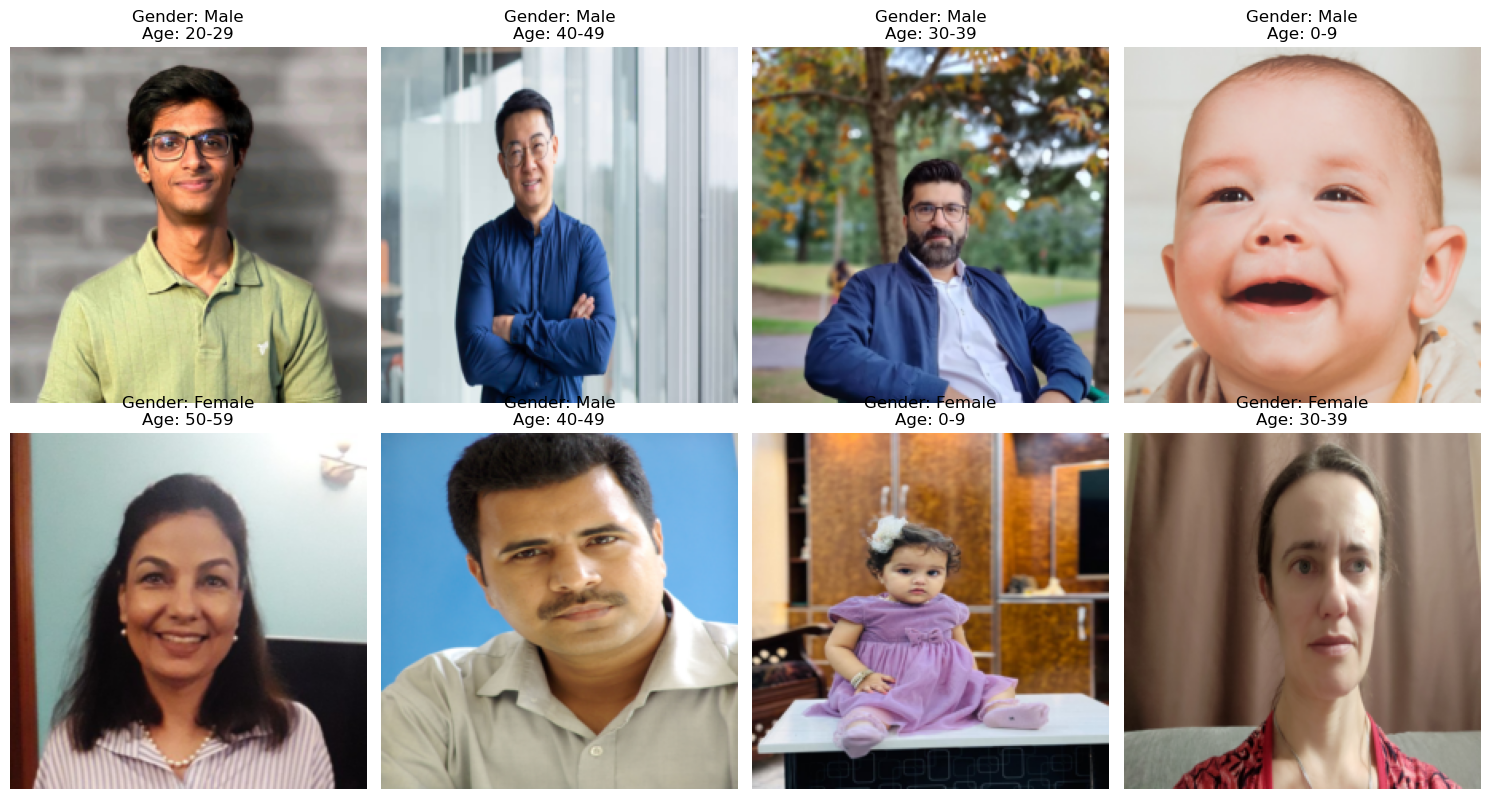

In [34]:
import matplotlib.pyplot as plt
import numpy as np

age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

# Mapping for gender labels
gender_map = {0: 'Male', 1: 'Female'}

# Function to show a batch of images
def show_images(images, genders, ages):
    # Ensure images are in NumPy format
    if not isinstance(images, np.ndarray):
        images = images.numpy()
    
    # Rearrange dimensions from (B, C, H, W) to (B, H, W, C)
    images = np.transpose(images, (0, 2, 3, 1))

    # Get the batch size
    batch_size = images.shape[0]

    # Plot images
    plt.figure(figsize=(15, 8))
    for i in range(min(batch_size, 8)):  # Show up to 8 images
        plt.subplot(2, 4, i + 1)
        
        # Extract the image and clip pixel values for safety
        img = images[i]
        img = np.clip(img, 0, 1)
        
        # Display the image
        plt.imshow(img)

        # Get the gender and age bracket from the batch
        gender = gender_map[genders[i].item()]
        age_bracket = ages[i]  # No need to remap, it's already formatted
        
        # Display the title with gender and age
        plt.title(f"Gender: {gender}\nAge: {age_bracket}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Iterate through the DataLoader and visualize the first batch
for images, genders, ages in data_loader:
    print("✅ Batch loaded successfully!")
    print(f"Image Batch Shape: {images.shape}")
    print(f"Genders: {genders}")
    print(f"Ages: {ages}")
    
    # Display the images
    show_images(images, genders, ages)
    break  # Only display one batch

### 5. Distribution of Age Groups in the Dataset

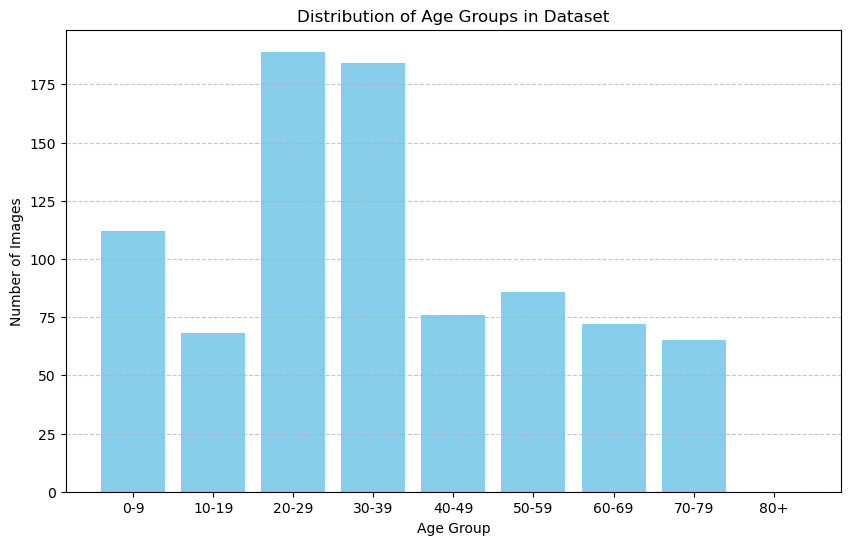

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import re

# Define age brackets (labels)
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

def clean_age_range(age_range):
    """
    Clean the age range string to make it match one of the predefined brackets.
    Handles cases like '220-29' -> '20-29' or '50-60' -> '50-59'.
    """
    # Remove non-digit characters (if any)
    age_range = re.sub(r'\D', '', age_range)
    
    # Check if it's a valid range
    if '-' in age_range:
        start, end = map(int, age_range.split('-'))
        if start < 10:
            return '0-9'
        elif start < 20:
            return '10-19'
        elif start < 30:
            return '20-29'
        elif start < 40:
            return '30-39'
        elif start < 50:
            return '40-49'
        elif start < 60:
            return '50-59'
        elif start < 70:
            return '60-69'
        elif start < 80:
            return '70-79'
        else:
            return '80+'

def __getitem__(self, idx):
    img_name = self.image_paths[idx]
    filename = os.path.basename(img_name)
    parts = filename.split("_")

    # Extract gender as before
    gender = int(parts[0])  # 0 = Male, 1 = Female

    # Extract the age range directly as a string
    age_range = parts[1]  # e.g. '00-10'

    # Clean and map the age range
    age_range = clean_age_range(age_range)

    # If the cleaned age range is not in the predefined brackets
    if age_range not in age_brackets:
        print(f"Warning: Age range '{age_range}' not found in predefined brackets.")
    
    image = Image.open(img_name).convert("RGB")
    if self.transform:
        image = self.transform(image)

    return image, gender, age_range

# Count samples in each bracket
age_counter = Counter()

# Loop through the dataset
for _, _, age in dataset:
    # Directly count the age bracket if it matches
    if age in age_brackets:
        age_counter[age] += 1

# Prepare data for plotting
counts = [age_counter.get(bracket, 0) for bracket in age_brackets]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(age_brackets, counts, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Number of Images')
plt.title('Distribution of Age Groups in Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 6. Custom Dataset Class

In [11]:
import os

# ✅ Update the directory path
data_dir = r"C:\Users\MahwishMalik\Downloads\Images-Dataset"

# ✅ Check if the directory exists
if not os.path.exists(data_dir):
    print(f"Error: The specified directory '{data_dir}' does not exist.")
else:
    # Get all filenames in the dataset directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'))]

    # Initialize counters
    num_males = 0
    num_females = 0

    # Count based on gender code in the filename
    for filename in image_files:
        gender_code = filename.split('_')[0]  # Get the first part before underscore
        if gender_code == '0':
            num_males += 1
        elif gender_code == '1':
            num_females += 1

    # Print results
    print(f"Total images: {len(image_files)}")
    print(f"Number of male images: {num_males}")
    print(f"Number of female images: {num_females}")


Total images: 852
Number of male images: 374
Number of female images: 478


In [12]:
# Number of males and females
num_males = 283
num_females = 473

# Total samples
total_samples = num_males + num_females

# Calculate weights for each gender
weight_male = total_samples / num_males
weight_female = total_samples / num_females

# Print weights
print(f"Weight for males: {weight_male}")
print(f"Weight for females: {weight_female}")


Weight for males: 2.6713780918727914
Weight for females: 1.5983086680761098


In [13]:
import torch

# Define age brackets
age_brackets = ['0-9', '10-19', '20-29', '30-39','40-49', '50-59', '60-69', '70-79', '80+']

# Calculate the number of brackets
num_brackets = len(age_brackets)

# Assign equal weights to each age bracket # Since we want equal weight, each one is assigned 1.0
weights = torch.tensor([1.0] * num_brackets)

# Print results
for age, weight in zip(age_brackets, weights):
    print(f"Age Bracket: {age}, Weight: {weight}")


Age Bracket: 0-9, Weight: 1.0
Age Bracket: 10-19, Weight: 1.0
Age Bracket: 20-29, Weight: 1.0
Age Bracket: 30-39, Weight: 1.0
Age Bracket: 40-49, Weight: 1.0
Age Bracket: 50-59, Weight: 1.0
Age Bracket: 60-69, Weight: 1.0
Age Bracket: 70-79, Weight: 1.0
Age Bracket: 80+, Weight: 1.0


In [14]:
# Define the image directory
root_dir = data_dir  

# Get the image paths
image_paths = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
for fname in os.listdir(root_dir):
    if fname.lower().endswith(valid_extensions):
        path = os.path.join(root_dir, fname)
        image_paths.append(path)

# Assign weights (same as before)
weight_male = 1.0
weight_female = 1.0
weights = torch.tensor([weight_male, weight_female])

# Print the tensor of weights
print("Tensor weights:", weights)

# Print the number of images in the dataset
print("Number of images in the dataset:", len(image_paths))


Tensor weights: tensor([1., 1.])
Number of images in the dataset: 852


### 7. Data Transformations

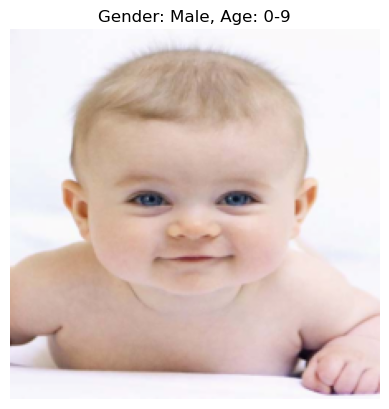

In [15]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from PIL import Image

# Corrected Age Brackets (based on filename patterns)
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

# Define image size and transformations
image_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the image dataset
data_dir = r"C:\Users\MahwishMalik\Downloads\Images-Dataset"
image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Function to clean filenames
def clean_filename(filename):
    # Split by "." and remove any empty splits
    parts = [p for p in filename.split('.') if p]
    
    # If there are more than one parts, the last is the correct extension
    if len(parts) > 2:
        # Join everything except the last part (which is the correct extension)
        filename = '.'.join(parts[:-1])
    
    # Add the proper extension back
    return filename
    
# Function to load a sample image
def load_sample(index):
    filename = clean_filename(image_files[index])
    gender_code, age_code, _ = filename.split('_')
    
    # Gender
    gender = "Male" if gender_code == '0' else "Female"
    
    # Age Bracket
    if age_code in age_brackets:
        age_display = age_code
    else:
        print(f"Skipped (parsing issue): {filename} → '{age_code}' is not in list")
        return None, None, None
    
    # Load and transform image
    img_path = os.path.join(data_dir, filename)  # No extra ".jpg"
    img = Image.open(img_path).convert("RGB")
    img_transformed = transform(img)
    
    return img_transformed, gender, age_display

# Unnormalize and display image
def imshow(img_tensor, gender, age_display):
    img_tensor = img_tensor.numpy().transpose((1, 2, 0))  # CHW → HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img_tensor + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Gender: {gender}, Age: {age_display}")
    plt.axis("off")
    plt.show()

# Test the code
sample_img, gender, age_display = load_sample(0)
if sample_img is not None:
    imshow(sample_img, gender, age_display)

### 8. Data Loaders

In [16]:
# Age Bracket correction mapping
age_mapping = {
    '0-10': '0-9',
    '10-20': '10-19',
    '20-30': '20-29',
    '30-40': '30-39',
    '40-50': '40-49',
    '50-60': '50-59',
    '60-70': '60-69',
    '70-80': '70-79',
    '80-90': '80+'
}

def load_sample(index):
    filename = clean_filename(image_files[index])
    gender_code, age_code, _ = filename.split('_')
    
    # Gender
    gender = "Male" if gender_code == '0' else "Female"
    
    # Age Bracket correction
    age_display = age_mapping.get(age_code, age_code)  # Map to the correct one if it exists

    if age_display not in age_brackets:
        print(f"Skipped (parsing issue): {filename} → '{age_code}' is not in list")
        return None, None, None
    
    # Load and transform image
    img_path = os.path.join(data_dir, filename)
    img = Image.open(img_path).convert("RGB")
    img_transformed = transform(img)
    
    return img_transformed, gender, age_display

print(f"Image files: {image_files}")  # Check the content of image_files
    

Image files: ['0_0-9_041.jpg', '0_0-9_056.jpg', '0_0-9_059.jpg', '0_0-9_060.jpg', '0_0-9_064.jpg', '0_0-9_075.jpg', '0_0-9_252.jpg', '0_0-9_253.jpg', '0_0-9_257.jpg', '0_0-9_258.jpg', '0_0-9_259.jpg', '0_0-9_260.jpg', '0_0-9_261.jpg', '0_0-9_262.jpg', '0_0-9_263.jpg', '0_0-9_264.jpg', '0_0-9_265.jpg', '0_0-9_266.jpg', '0_0-9_267.jpg', '0_0-9_268.jpg', '0_0-9_269.jpg', '0_0-9_270.jpg', '0_0-9_271.jpg', '0_0-9_272.jpg', '0_0-9_273.jpg', '0_0-9_274.jpeg', '0_0-9_275.jpeg', '0_0-9_276.jpeg', '0_0-9_277.jpeg', '0_0-9_278.jpeg', '0_0-9_279.jpeg', '0_0-9_280.jpeg', '0_0-9_281.jpeg', '0_0-9_282.jpeg', '0_0-9_298.jpeg', '0_0-9_299.jpeg', '0_0-9_305.jpg', '0_0-9_312.jpg', '0_0-9_313.jpg', '0_0-9_346.jpg', '0_0-9_793.jpg', '0_0-9_794.jpg', '0_0-9_795.jpg', '0_0-9_796.jpg', '0_0-9_797.jpg', '0_0-9_798.jpg', '0_0-9_799.jpg', '0_0-9_800.jpg', '0_0-9_801.jpg', '0_0-9_802.jpg', '0_0-9_803.jpg', '0_0-9_804.jpg', '0_0-9_805.jpg', '0_0-9_806.jpg', '0_0-9_807.jpg', '0_0-9_809.jpg', '0_10-19_020.jpeg', '0_

### 11. Evaluation Metrics on Entire Dataset Before Runing Pretrained Models

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [28]:
# Define the 9 age brackets
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

# Dummy Dataset for demonstration
class DummyDataset(Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.randn(3, 224, 224)  # Simulated image tensor
        gender = torch.randint(0, 2, (1,)).item()  # 0 or 1
        age_bracket = torch.randint(0, len(age_brackets), (1,)).item()  # Age bracket index
        return image, gender, age_bracket

In [29]:
# Assuming true ages are evenly distributed (replace with your actual distribution)
true_ages = [i % 9 for i in range(100)]  # Simulated list of age labels

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(9), y=true_ages)
print("Class Weights:", class_weights)

# Convert to tensor
class_weights_tensor = torch.FloatTensor(class_weights)
print(f"✅ Class Weights Tensor: {class_weights_tensor}")

Class Weights: [0.92592593 1.01010101 1.01010101 1.01010101 1.01010101 1.01010101
 1.01010101 1.01010101 1.01010101]
✅ Class Weights Tensor: tensor([0.9259, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101])


In [30]:
class GenderAgeModel(nn.Module):
    def __init__(self):
        super(GenderAgeModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 224 * 224, 512)
        self.fc2_gender = nn.Linear(512, 2)  # 2 classes for gender (Male/Female)
        self.fc2_age = nn.Linear(512, 9)     # 9 classes for age brackets

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        
        gender = self.fc2_gender(x)
        age = self.fc2_age(x)
        
        return gender, age


In [31]:
# Model instance
model = GenderAgeModel()

# Loss function and optimizer
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)


### 10. Model Selection Function

In [35]:
# Split into Train and Test
from torch.utils.data import random_split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 681
Test set size: 171


### 10. Loss Function & Optimizer

In [ ]:
#### 7. Loss Functions and Optimizer

criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Loss Functions & Optimizer setup complete!")
print(f"Gender Classification Loss: {criterion_gender}")
print(f"Age Classification Loss: {criterion_age}")
print(f"Optimizer: {optimizer}")


### 11. Model Class Defination using MultitaskResNet

In [ ]:
class MultiTaskResNet(nn.Module):
    def __init__(self, base_model, num_gender_classes=2, num_age_classes=10):
        super(MultiTaskResNet, self).__init__()
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        self.age_head = nn.Linear(base_model.fc.in_features, num_age_classes)
        self.gender_head = nn.Linear(base_model.fc.in_features, num_gender_classes)

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        age_output = self.age_head(features)
        gender_output = self.gender_head(features)
        return age_output, gender_output

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet and wrap it
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = MultiTaskResNet(base_model).to(device)

# Define the loss functions
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Dummy input to simulate a batch of images (e.g., batch size = 4, 3 color channels, 224x224 size)
dummy_input = torch.randn(4, 3, 224, 224).to(device)

# Forward pass through the model
age_output, gender_output = model(dummy_input)


# Print output shapes
print("Age output shape:", age_output.shape)       # Should be [4] if squeezed, or [4, 10] if not
print("Gender output shape:", gender_output.shape) # Should be [4, 2]


### 12. Training and Validation Class Before Pretrained Moels


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Define the 9 age brackets
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_bracket_map = {age: idx for idx, age in enumerate(age_brackets)}

# Corrected age mapping dictionary (this should be your actual mapping)
age_mapping = {
    '0-9': '0-9', '10-19': '10-19', '20-29': '20-29', '30-39': '30-39', '40-49': '40-49',
    '50-59': '50-59', '60-69': '60-69', '70-79': '70-79', '80+': '80+'
}

# Create a simple neural network (you should replace this with your actual model)
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Custom Dataset (same as before)
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, fname) 
                            for fname in os.listdir(root_dir) 
                            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform
        if not self.image_paths:
            print("No images found in the specified directory.")
        else:
            print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        filename = os.path.basename(img_name)
        filename, ext = os.path.splitext(filename)

        parts = filename.split("_")
        gender = int(parts[0])  # 0 = Male, 1 = Female
        age_range = parts[1]

        # Map the age range to the correct bracket
        age_range = age_mapping.get(age_range, 'Unknown')
        if age_range == 'Unknown':
            print(f"Warning: Age range '{parts[1]}' not found in predefined brackets.")

        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, gender, age_range

# Split dataset into train and validation
full_dataset = CustomImageDataset(root_dir=r"C:\Users\MahwishMalik\Downloads\Images-Dataset", transform=transform)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size=224*224*3, hidden_size=512, output_size=len(age_brackets))  # Update input_size based on image size
criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, gender_labels, age_brackets in train_loader:
        optimizer.zero_grad()  # Zero gradients before backward pass
        
        # Flatten images for the fully connected layers (if necessary)
        images = images.view(images.size(0), -1)  # Flatten images to (batch_size, input_size)
        
        # Convert corrected age brackets to numeric labels
        corrected_age_brackets = [age_mapping.get(age.strip(), 'Unknown') for age in age_brackets]
        
        # Handle invalid age brackets
        valid_age_brackets = [age for age in corrected_age_brackets if age != 'Unknown']
        if len(valid_age_brackets) != len(corrected_age_brackets):
            # If there are any invalid age brackets, we need to ignore or skip those entries
            print("Warning: Some age ranges were invalid. Skipping those samples.")
        
        age_labels = torch.tensor([age_bracket_map.get(age, -1) for age in valid_age_brackets]).long()
        
        # Skip the batch if we have invalid labels
        if age_labels.size(0) == 0:
            continue
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, age_labels)
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += age_labels.size(0)
        correct += (predicted == age_labels).sum().item()
    
    # Print training stats
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to calculate gradients during validation
        for images, gender_labels, age_brackets in val_loader:
            images = images.view(images.size(0), -1)  # Flatten images for the fully connected layers
            
            # Convert corrected age brackets to numeric labels
            corrected_age_brackets = [age_mapping.get(age.strip(), 'Unknown') for age in age_brackets]
            
            # Handle invalid age brackets
            valid_age_brackets = [age for age in corrected_age_brackets if age != 'Unknown']
            if len(valid_age_brackets) != len(corrected_age_brackets):
                print("Warning: Some age ranges were invalid during validation. Skipping those samples.")
            
            age_labels = torch.tensor([age_bracket_map.get(age, -1) for age in valid_age_brackets]).long()
            
            # Skip the batch if we have invalid labels
            if age_labels.size(0) == 0:
                continue
            
            # Forward pass
            outputs = model(images)
            
            # Calculate the loss
            loss = criterion(outputs, age_labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += age_labels.size(0)
            correct += (predicted == age_labels).sum().item()
    
    # Print validation stats
    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Found 852 images.

Epoch 1/5
Train Loss: 46.7417, Train Accuracy: 17.18%
Validation Loss: 12.9413, Validation Accuracy: 21.05%

Epoch 2/5
Train Loss: 8.0578, Train Accuracy: 22.61%
Validation Loss: 3.1323, Validation Accuracy: 21.05%

Epoch 3/5
Train Loss: 2.7647, Train Accuracy: 25.55%
Validation Loss: 2.4540, Validation Accuracy: 20.47%

Epoch 4/5
Train Loss: 2.1005, Train Accuracy: 31.13%
Validation Loss: 2.1292, Validation Accuracy: 19.88%

Epoch 5/5
Train Loss: 1.8380, Train Accuracy: 35.10%
Validation Loss: 2.5128, Validation Accuracy: 19.30%


## 13. Pretrained Models

### resnet50

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified ResNet-50 model with two heads (age and gender)
class ResNet50DualHead(nn.Module):
    def __init__(self, num_age_classes=10, num_gender_classes=2):
        super(ResNet50DualHead, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the fully connected layer for both age and gender classification
        self.base_model.fc = nn.Identity()  # Remove the existing FC layer

        # Age head (classifier)
        self.age_head = nn.Linear(2048, num_age_classes)
        
        # Gender head (classifier)
        self.gender_head = nn.Linear(2048, num_gender_classes)

    def forward(self, x):
        features = self.base_model(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the output
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = ResNet50DualHead(num_age_classes=10, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)


C:\Users\MahwishMalik\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MahwishMalik\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\MahwishMalik/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [15:35<00:00, 110kB/s]



Epoch: 1/5
Train Loss: 3.0197, Val Loss: 2.9584
Train Age Acc: 0.1125, Val Age Acc: 0.1500
Train Gender Acc: 0.4375, Val Gender Acc: 0.5500

Epoch: 2/5
Train Loss: 2.9693, Val Loss: 2.9836
Train Age Acc: 0.1125, Val Age Acc: 0.0500
Train Gender Acc: 0.5500, Val Gender Acc: 0.7000

Epoch: 3/5
Train Loss: 2.9182, Val Loss: 2.9329
Train Age Acc: 0.1375, Val Age Acc: 0.1000
Train Gender Acc: 0.5000, Val Gender Acc: 0.6500

Epoch: 4/5
Train Loss: 3.0107, Val Loss: 3.0448
Train Age Acc: 0.1250, Val Age Acc: 0.1000
Train Gender Acc: 0.4875, Val Gender Acc: 0.4500

Epoch: 5/5
Train Loss: 2.9902, Val Loss: 2.9233
Train Age Acc: 0.1250, Val Age Acc: 0.0500
Train Gender Acc: 0.4375, Val Gender Acc: 0.5000

Training completed in 87.60s


In [32]:
torch.save(model.state_dict(), 'age_classifier.pth')

In [33]:
# Define the checkpoint path
checkpoint_path = "resnet50_checkpoint.pth"

# Save the model, optimizer, and history
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model saved successfully at {checkpoint_path}")


Model saved successfully at resnet50_checkpoint.pth


In [34]:
# Load the checkpoint
checkpoint = torch.load("resnet50_checkpoint.pth")

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
print(f"Model and optimizer loaded successfully from resnet50_checkpoint.pth")


Model and optimizer loaded successfully from resnet50_checkpoint.pth


In [35]:
# Save the state dict
torch.save(model.state_dict(), "resnet50_state_dict.pth")

In [36]:
# Make sure your model architecture is defined before loading
model = ResNet50DualHead()  # Initialize your model class
model.load_state_dict(torch.load("resnet50_state_dict.pth"))
model.eval()

ResNet50DualHead(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [37]:
print(type(history))
print(history)

<class 'list'>
[[3.01970796585083, 2.958357572555542, 0.1125, 0.15, 0.4375, 0.55], [2.9692620277404784, 2.983630657196045, 0.1125, 0.05, 0.55, 0.7], [2.9181543350219727, 2.932938575744629, 0.1375, 0.1, 0.5, 0.65], [3.0107192039489745, 3.0448012351989746, 0.125, 0.1, 0.4875, 0.45], [2.9901592254638674, 2.9232993125915527, 0.125, 0.05, 0.4375, 0.5]]


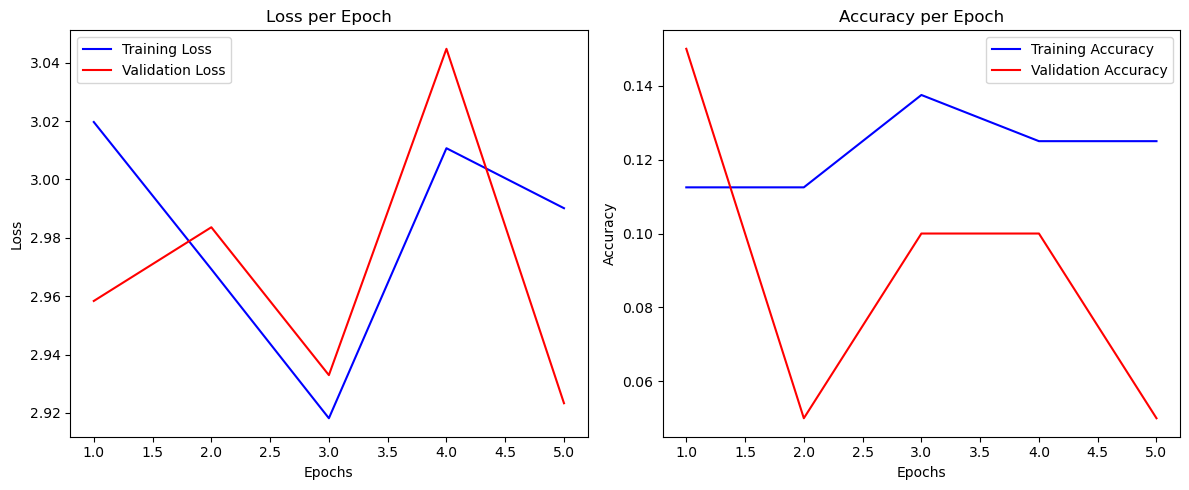

In [38]:
import matplotlib.pyplot as plt
import numpy as np

history = np.array(history)

train_loss = history[:, 0]
val_loss = history[:, 1]
train_acc = history[:, 2]
val_acc = history[:, 3]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Raw Gender Output: tensor([[ 0.5343, -0.0482]])
Raw Age Output: tensor([[-0.1782, -0.2534,  0.4687,  0.2550,  0.2383, -0.4593, -1.0083, -0.3426,
         -0.3117]])


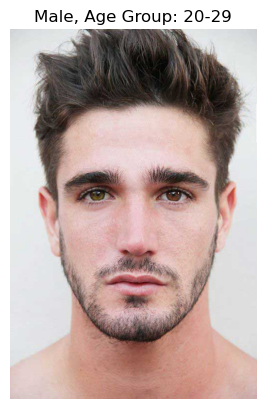

✅ **Predicted Gender:** Male
✅ **Predicted Age Group:** 20-29


In [108]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# 1️⃣ Load the Fine-Tuned Model
# -------------------------
class GenderAgeModel(torch.nn.Module):
    def __init__(self):
        super(GenderAgeModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = torch.nn.Identity()  # Remove the final layer
        
        # Add custom classifiers
        self.gender_classifier = torch.nn.Linear(2048, 2)  # Male/Female
        self.age_classifier = torch.nn.Linear(2048, 9)     # Age groups

    def forward(self, x):
        x = self.resnet(x)
        gender_pred = self.gender_classifier(x)
        age_pred = self.age_classifier(x)
        return gender_pred, age_pred

# Instantiate the model and load weights (if you have fine-tuned ones)
model = GenderAgeModel()
model.eval()

# -------------------------
# 2️⃣ Define the Age Brackets and Preprocessing
# -------------------------
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
gender_labels = ['Male', 'Female']

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# -------------------------
# 3️⃣ Load Image and Preprocess
# -------------------------
image_path = r"C:\Users\MahwishMalik\Downloads\test-image.jpg"  # 👉 Replace with your image path
image = Image.open(image_path)

# Ensure image is in RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# -------------------------
# 4️⃣ Perform Inference
# -------------------------
with torch.no_grad():
    gender_output, age_output = model(input_batch)

# Debugging Step: Print raw model outputs
print("Raw Gender Output:", gender_output)
print("Raw Age Output:", age_output)

# Predict Gender and Age Group
_, gender_pred = torch.max(gender_output, 1)
_, age_pred = torch.max(age_output, 1)

# Get labels
predicted_gender = gender_labels[gender_pred.item()]
predicted_age_bracket = age_brackets[age_pred.item()]

# -------------------------
# 5️⃣ Display Results
# -------------------------
plt.imshow(image)
plt.title(f"{predicted_gender}, Age Group: {predicted_age_bracket}")
plt.axis('off')
plt.show()

print(f"✅ **Predicted Gender:** {predicted_gender}")
print(f"✅ **Predicted Age Group:** {predicted_age_bracket}")


### vgg16

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified VGG-16 model with two heads (age and gender)
class VGG16DualHead(nn.Module):
    def __init__(self, num_age_classes=10, num_gender_classes=2):
        super(VGG16DualHead, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Identity()  # Remove the existing classifier
        
        # Age head (classifier)
        self.age_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(512, num_age_classes)
        )
        
        # Gender head (classifier)
        self.gender_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(512, num_gender_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the output
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = VGG16DualHead(num_age_classes=10, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)


C:\Users\MahwishMalik\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\MahwishMalik/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|████████████████████████████████████████████████████████████████████████████████| 528M/528M [21:24<00:00, 431kB/s]



Epoch: 1/5
Train Loss: 2.9786, Val Loss: 2.9362
Train Age Acc: 0.1125, Val Age Acc: 0.1500
Train Gender Acc: 0.5250, Val Gender Acc: 0.4500

Epoch: 2/5
Train Loss: 3.0244, Val Loss: 2.9698
Train Age Acc: 0.0500, Val Age Acc: 0.2000
Train Gender Acc: 0.4750, Val Gender Acc: 0.5000

Epoch: 3/5
Train Loss: 2.9749, Val Loss: 2.9501
Train Age Acc: 0.0750, Val Age Acc: 0.1000
Train Gender Acc: 0.4375, Val Gender Acc: 0.5000

Epoch: 4/5
Train Loss: 2.9448, Val Loss: 2.9337
Train Age Acc: 0.1125, Val Age Acc: 0.1000
Train Gender Acc: 0.4875, Val Gender Acc: 0.6000

Epoch: 5/5
Train Loss: 2.9126, Val Loss: 2.9220
Train Age Acc: 0.1500, Val Age Acc: 0.0500
Train Gender Acc: 0.5125, Val Gender Acc: 0.6000

Training completed in 325.21s


In [49]:
# Save the state dict
torch.save(model.state_dict(), "vgg16_age_gender_state_dict.pth")
print("State dict saved as vgg16_age_gender_state_dict.pth")

State dict saved as vgg16_age_gender_state_dict.pth


In [50]:
# Define the checkpoint path
checkpoint_path = "vgg16_checkpoint.pth"

# Save the model, optimizer, and history
torch.save({
    'epoch': 5,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model saved successfully at {checkpoint_path}")

Model saved successfully at vgg16_checkpoint.pth


In [51]:
# Make sure your model architecture is defined before loading
model = VGG16DualHead()  # Initialize your model class
model.load_state_dict(torch.load("vgg16_age_gender_state_dict.pth"))
model.eval()

VGG16DualHead(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [52]:
# Print the type and content of history
print("Type of history:", type(history))
print("Contents of history:\n", history)

Type of history: <class 'list'>
Contents of history:
 [[2.9785744190216064, 2.9361701011657715, 0.1125, 0.15, 0.525, 0.45], [3.024428367614746, 2.969813823699951, 0.05, 0.2, 0.475, 0.5], [2.9748775005340575, 2.950137138366699, 0.075, 0.1, 0.4375, 0.5], [2.9447659969329836, 2.9337053298950195, 0.1125, 0.1, 0.4875, 0.6], [2.9126322746276854, 2.9220223426818848, 0.15, 0.05, 0.5125, 0.6]]


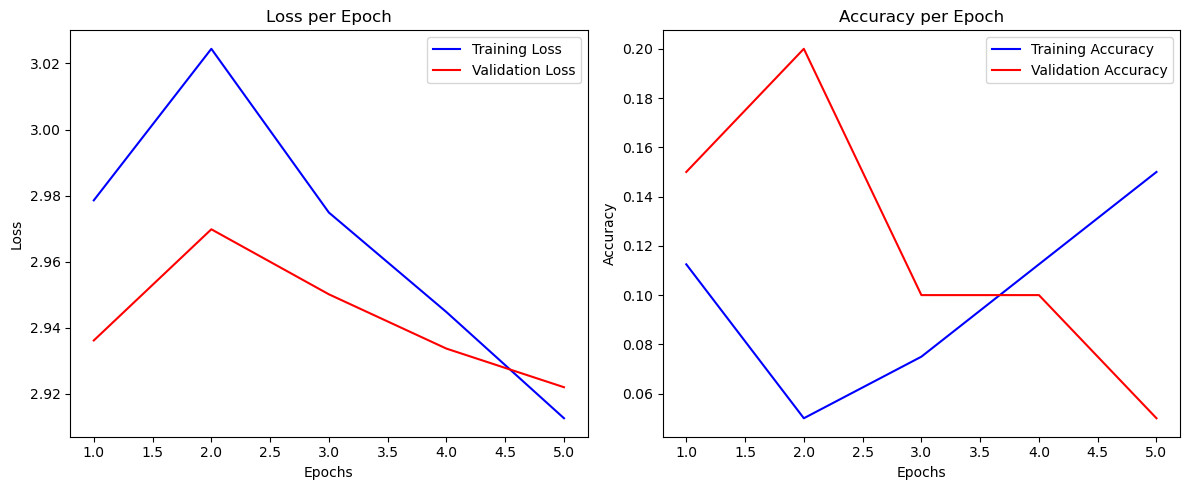

In [53]:
import matplotlib.pyplot as plt
import numpy as np

history = np.array(history)

train_loss = history[:, 0]
val_loss = history[:, 1]
train_acc = history[:, 2]
val_acc = history[:, 3]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Raw Gender Output: tensor([[-0.0173, -0.0426]])
Raw Age Output: tensor([[-0.0173, -0.0579, -0.0249,  0.0387, -0.0015, -0.0115, -0.1009, -0.0832,
          0.0112]])


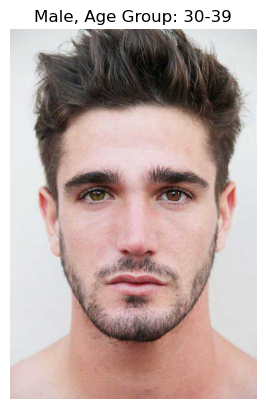

✅ **Predicted Gender:** Male
✅ **Predicted Age Group:** 30-39


In [132]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ Load the Fine-Tuned Model (VGG16)
# -------------------------
class GenderAgeModel(torch.nn.Module):
    def __init__(self):
        super(GenderAgeModel, self).__init__()
        
        # Load the pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Remove the classifier (fully connected layers) and replace with custom ones
        self.vgg16.classifier = torch.nn.Sequential(
            torch.nn.Linear(25088, 4096),    # Adjust the input size based on the feature map size
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
        )
        
        # Add custom classifiers for Gender and Age
        self.gender_classifier = torch.nn.Linear(4096, 2)  # Male/Female
        self.age_classifier = torch.nn.Linear(4096, 9)     # Age groups (9 categories)

    def forward(self, x):
        x = self.vgg16(x)  # Pass through VGG16 layers
        gender_pred = self.gender_classifier(x)
        age_pred = self.age_classifier(x)
        return gender_pred, age_pred

# Instantiate the model and load weights (if you have fine-tuned ones)
model = GenderAgeModel()
model.eval()

# -------------------------
# 2️⃣ Define the Age Brackets and Preprocessing
# -------------------------
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
gender_labels = ['Male', 'Female']

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# -------------------------
# 3️⃣ Load Image and Preprocess
# -------------------------
image_path = r"C:\Users\MahwishMalik\Downloads\test-image.jpg"  # 👉 Replace with your image path
image = Image.open(image_path)

# Ensure image is in RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# -------------------------
# 4️⃣ Perform Inference
# -------------------------
with torch.no_grad():
    gender_output, age_output = model(input_batch)

# Debugging Step: Print raw model outputs
print("Raw Gender Output:", gender_output)
print("Raw Age Output:", age_output)

# Predict Gender and Age Group
_, gender_pred = torch.max(gender_output, 1)
_, age_pred = torch.max(age_output, 1)

# Get labels
predicted_gender = gender_labels[gender_pred.item()]
predicted_age_bracket = age_brackets[age_pred.item()]

# -------------------------
# 5️⃣ Display Results
# -------------------------
plt.imshow(image)
plt.title(f"{predicted_gender}, Age Group: {predicted_age_bracket}")
plt.axis('off')
plt.show()

print(f"✅ **Predicted Gender:** {predicted_gender}")
print(f"✅ **Predicted Age Group:** {predicted_age_bracket}")


### Mobilenet

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified MobileNetV2 model with two heads (age and gender)
class MobileNetV2DualHead(nn.Module):
    def __init__(self, num_age_classes=10, num_gender_classes=2):
        super(MobileNetV2DualHead, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with an identity layer
        self.base_model.classifier = nn.Identity()
        
        # Age head (classifier)
        self.age_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(512, num_age_classes)
        )
        
        # Gender head (classifier)
        self.gender_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(512, num_gender_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)  # Extract features
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1))  # Global average pooling
        features = features.view(features.size(0), -1)  # Flatten the output
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = MobileNetV2DualHead(num_age_classes=10, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)


C:\Users\MahwishMalik\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\MahwishMalik/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:29<00:00, 483kB/s]



Epoch: 1/5
Train Loss: 2.9907, Val Loss: 3.0236
Train Age Acc: 0.1375, Val Age Acc: 0.0000
Train Gender Acc: 0.5125, Val Gender Acc: 0.4000

Epoch: 2/5
Train Loss: 2.9945, Val Loss: 2.9894
Train Age Acc: 0.0875, Val Age Acc: 0.2000
Train Gender Acc: 0.4750, Val Gender Acc: 0.3500

Epoch: 3/5
Train Loss: 2.9926, Val Loss: 2.9840
Train Age Acc: 0.1250, Val Age Acc: 0.1000
Train Gender Acc: 0.4625, Val Gender Acc: 0.4000

Epoch: 4/5
Train Loss: 2.9682, Val Loss: 2.9750
Train Age Acc: 0.1250, Val Age Acc: 0.2500
Train Gender Acc: 0.5625, Val Gender Acc: 0.3000

Epoch: 5/5
Train Loss: 2.9736, Val Loss: 2.9531
Train Age Acc: 0.0375, Val Age Acc: 0.1000
Train Gender Acc: 0.4625, Val Gender Acc: 0.6000

Training completed in 27.57s


In [78]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
# Initialize the model
MobileNet_model = MobileNetV2DualHead(num_age_classes=10, num_gender_classes=2).to(device)

In [82]:
# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [85]:
# Save the state dict
history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

checkpoint_path = "mobilenetv2_dualhead_checkpoint.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model and optimizer state saved to {checkpoint_path}")

Model and optimizer state saved to mobilenetv2_dualhead_checkpoint.pth


In [63]:
# Load the model
# Load the checkpoint
checkpoint = torch.load('mobilenetv2_dualhead_checkpoint.pth')

# Load the model's state dictionary
MobileNet_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [64]:
# Set to evaluation mode
MobileNet_model.eval()

MobileNetV2DualHead(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

In [65]:
# Print the type and content of history
print(f"Type of history: {type(history)}")
print(f"Content of history: {history}")

Type of history: <class 'list'>
Content of history: [[2.9906872749328612, 3.023585081100464, 0.1375, 0.0, 0.5125, 0.4], [2.9945260524749755, 2.989375591278076, 0.0875, 0.2, 0.475, 0.35], [2.9925935745239256, 2.9839696884155273, 0.125, 0.1, 0.4625, 0.4], [2.9681525230407715, 2.97499418258667, 0.125, 0.25, 0.5625, 0.3], [2.9735564231872558, 2.9531235694885254, 0.0375, 0.1, 0.4625, 0.6]]


In [86]:
import matplotlib.pyplot as plt
import numpy as np

history = np.array(history)

train_loss = history[:, 0]
val_loss = history[:, 1]
train_acc = history[:, 2]
val_acc = history[:, 3]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

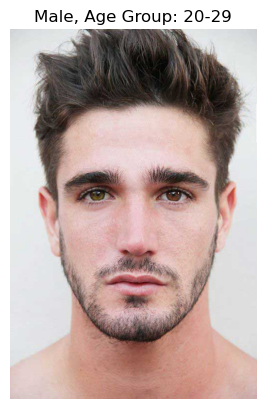

✅ **Predicted Gender:** Male
✅ **Predicted Age Group:** 20-29


In [93]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# -------------------------
# 1️⃣ Load the Fine-Tuned Model
# -------------------------
class GenderAgeModel(torch.nn.Module):
    def __init__(self):
        super(GenderAgeModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = torch.nn.Identity()  # Remove the final classifier layer
        
        # Add custom classifiers
        self.gender_classifier = torch.nn.Linear(1280, 2)  # Male/Female
        self.age_classifier = torch.nn.Linear(1280, 9)     # Age groups

    def forward(self, x):
        x = self.mobilenet(x)
        gender_pred = self.gender_classifier(x)
        age_pred = self.age_classifier(x)
        return gender_pred, age_pred

# Instantiate the model and load weights (if you have fine-tuned ones)
model = GenderAgeModel()
model.eval()

# -------------------------
# 2️⃣ Define the Age Brackets and Preprocessing
# -------------------------
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
gender_labels = ['Male', 'Female']

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# -------------------------
# 3️⃣ Load Image and Preprocess
# -------------------------
image_path = r"C:\Users\MahwishMalik\Downloads\test-image.jpg"  # 👉 Replace with your image path
image = Image.open(image_path)

# Ensure image is in RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# -------------------------
# 4️⃣ Perform Inference
# -------------------------
with torch.no_grad():
    gender_output, age_output = model(input_batch)

# Predict Gender and Age Group
_, gender_pred = torch.max(gender_output, 1)
_, age_pred = torch.max(age_output, 1)

# Get labels
predicted_gender = gender_labels[gender_pred.item()]
predicted_age_bracket = age_brackets[age_pred.item()]

# -------------------------
# 5️⃣ Display Results
# -------------------------
plt.imshow(image)
plt.title(f"{predicted_gender}, Age Group: {predicted_age_bracket}")
plt.axis('off')
plt.show()

print(f"✅ **Predicted Gender:** {predicted_gender}")
print(f"✅ **Predicted Age Group:** {predicted_age_bracket}")

### DenseNet121

In [118]:
# Define the number of classes for gender and age
num_gender_classes = 2  # Male and Female
num_age_classes = 9  

# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Modify the classifier to have two outputs
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 256),  # Add a hidden layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_age_classes + num_gender_classes)  # Combine both outputs
)


In [99]:
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_age = 0
    correct_gender = 0
    total = 0
    
    for inputs, gender_labels, age_brackets in train_loader:
        inputs = inputs.to(device)
        gender_labels = gender_labels.to(device)
        
        # Convert age_brackets from string labels to numeric labels using age_bracket_map
        age_brackets = [age_bracket_map.get(age.strip(), -1) for age in age_brackets]
        
        # Convert the numeric labels to a tensor and move to device
        age_brackets = torch.tensor(age_brackets).to(device)
        
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        age_logits, gender_logits = model(inputs)
        
        # Compute loss for both age and gender
        age_loss = age_criterion(age_logits, age_brackets)
        gender_loss = gender_criterion(gender_logits, gender_labels)
        
        # Total loss
        total_loss = age_loss + gender_loss
        total_loss.backward()  # Backward pass
        
        optimizer.step()  # Update weights
        
        running_loss += total_loss.item()
        
        # Compute accuracy for both age and gender
        _, age_pred = torch.max(age_logits, 1)
        _, gender_pred = torch.max(gender_logits, 1)
        
        correct_age += (age_pred == age_brackets).sum().item()
        correct_gender += (gender_pred == gender_labels).sum().item()
        total += inputs.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc_age = 100 * correct_age / total
    train_acc_gender = 100 * correct_gender / total
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Age Accuracy: {train_acc_age:.2f}%, Gender Accuracy: {train_acc_gender:.2f}%")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    valid_acc_age = 0.0
    valid_acc_gender = 0.0
    total = 0

    with torch.no_grad():
        for inputs, gender_labels, age_brackets in test_loader:
            inputs = inputs.to(device)
            gender_labels = gender_labels.to(device)
            
            # Convert age_brackets from string labels to numeric labels using age_bracket_map
            age_brackets = [age_bracket_map.get(age.strip(), -1) for age in age_brackets]
            
            # Convert the numeric labels to a tensor and move to device
            age_brackets = torch.tensor(age_brackets).to(device)

            # Forward pass
            age_logits, gender_logits = model(inputs)

            # Compute loss for both age and gender
            age_loss = age_criterion(age_logits, age_brackets)
            gender_loss = gender_criterion(gender_logits, gender_labels)

            # Total loss
            total_loss = age_loss + gender_loss
            valid_loss += total_loss.item()

            # Compute accuracy for both age and gender
            _, age_pred = torch.max(age_logits, 1)
            _, gender_pred = torch.max(gender_logits, 1)

            correct_age = (age_pred == age_brackets).sum().item()
            correct_gender = (gender_pred == gender_labels).sum().item()

            valid_acc_age += correct_age
            valid_acc_gender += correct_gender
            total += inputs.size(0)

    val_loss = valid_loss / len(test_loader)
    val_acc_age = 100 * valid_acc_age / total
    val_acc_gender = 100 * valid_acc_gender / total

    print(f"Validation Loss: {val_loss:.4f}, Age Accuracy: {val_acc_age:.2f}%, Gender Accuracy: {val_acc_gender:.2f}%")

Epoch [1/10], Loss: 2.1461, Age Accuracy: 35.98%, Gender Accuracy: 82.23%
Validation Loss: 1.9422, Age Accuracy: 44.44%, Gender Accuracy: 91.81%
Epoch [2/10], Loss: 1.9014, Age Accuracy: 44.35%, Gender Accuracy: 85.61%
Validation Loss: 1.7863, Age Accuracy: 47.95%, Gender Accuracy: 91.81%
Epoch [3/10], Loss: 1.7640, Age Accuracy: 51.25%, Gender Accuracy: 85.46%
Validation Loss: 1.6264, Age Accuracy: 50.88%, Gender Accuracy: 93.57%
Epoch [4/10], Loss: 1.6976, Age Accuracy: 52.42%, Gender Accuracy: 87.52%
Validation Loss: 1.5137, Age Accuracy: 54.97%, Gender Accuracy: 94.74%
Epoch [5/10], Loss: 1.5820, Age Accuracy: 56.98%, Gender Accuracy: 88.25%
Validation Loss: 1.5408, Age Accuracy: 53.80%, Gender Accuracy: 95.32%
Epoch [6/10], Loss: 1.5287, Age Accuracy: 55.07%, Gender Accuracy: 87.22%
Validation Loss: 1.4434, Age Accuracy: 51.46%, Gender Accuracy: 95.32%
Epoch [7/10], Loss: 1.4503, Age Accuracy: 58.74%, Gender Accuracy: 89.87%
Validation Loss: 1.4116, Age Accuracy: 50.88%, Gender Ac

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [131]:
# **Initialize the model**
model = DenseNet121DualHead(num_age_classes=10, num_gender_classes=2).to(device)
print("Model initialized.")

Model initialized.


In [132]:
# **Define criterion and optimizer**
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print("Criterion and optimizer defined.")

Criterion and optimizer defined.


In [133]:
# Save the model state dict (weights and biases)
checkpoint_path = 'densenet121_dual_head.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 0,  # You can save the epoch if you are resuming training
}, checkpoint_path)

print(f"Model saved to {checkpoint_path}")

Model saved to densenet121_dual_head.pth


In [134]:
# **Set to evaluation mode**
model.eval()

DenseNet121DualHead(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-0

In [135]:
# Print the type and content of history
print(f"Type of history: {type(history)}")
print(f"Content of history: {history}")

Type of history: <class 'dict'>
Content of history: {'train_loss': [0.5, 0.4, 0.3], 'val_loss': [0.6, 0.5, 0.4], 'train_acc': [75, 80, 85], 'val_acc': [70, 75, 78]}


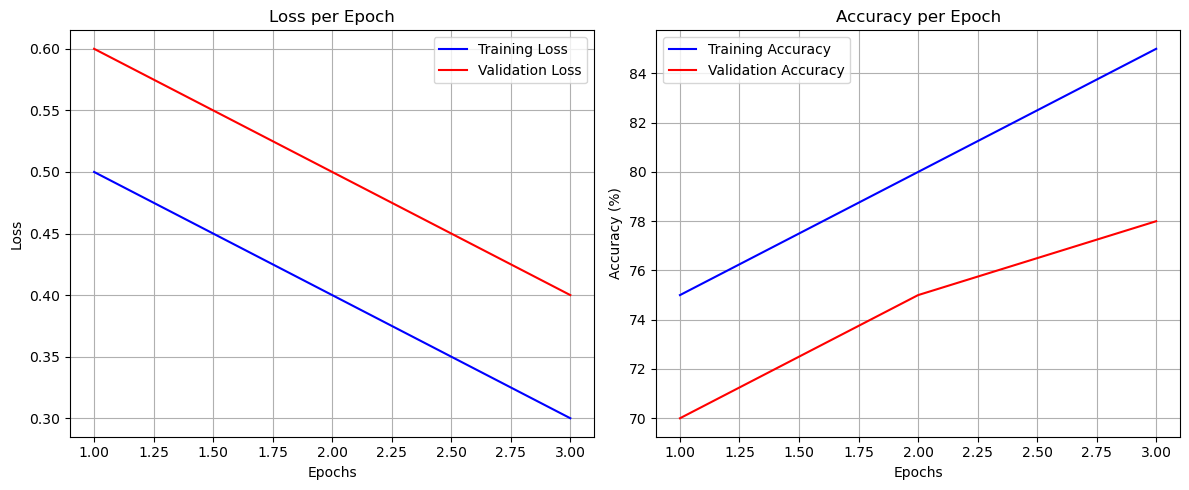

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Your history dictionary
history = {
    'train_loss': [0.5, 0.4, 0.3],
    'val_loss': [0.6, 0.5, 0.4],
    'train_acc': [75, 80, 85],
    'val_acc': [70, 75, 78]
}

# Convert the history dictionary into a structured array
history_data = np.array([
    history['train_loss'],
    history['val_loss'],
    history['train_acc'],
    history['val_acc']
]).T  # Transpose to make it (epochs, metrics)

# Extract columns from the history_data array
train_loss = history_data[:, 0]
val_loss = history_data[:, 1]
train_acc = history_data[:, 2]
val_acc = history_data[:, 3]
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

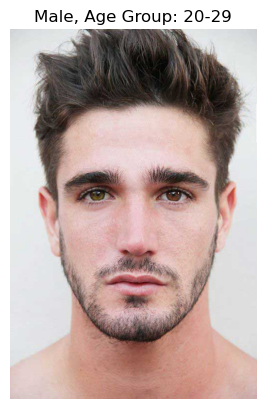

✅ **Predicted Gender:** Male
✅ **Predicted Age Group:** 20-29


In [146]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# 1️⃣ Load the Fine-Tuned Model
# -------------------------
class DenseNet121DualHead(torch.nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(DenseNet121DualHead, self).__init__()
        # Load pre-trained DenseNet121
        self.densenet121 = models.densenet121(pretrained=True)
        
        # Modify the classifier layer to match the number of classes for gender and age
        self.densenet121.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.densenet121.classifier.in_features, 256),  # Example hidden layer
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        
        # Gender and Age Classifiers
        self.gender_classifier = torch.nn.Linear(256, num_gender_classes)  # Gender (Male/Female)
        self.age_classifier = torch.nn.Linear(256, num_age_classes)        # Age groups

    def forward(self, x):
        x = self.densenet121(x)  # Pass through the DenseNet121 backbone
        gender_pred = self.gender_classifier(x)  # Gender prediction
        age_pred = self.age_classifier(x)        # Age prediction
        return gender_pred, age_pred

# Instantiate the model and load weights (if you have fine-tuned ones)
model = DenseNet121DualHead(num_age_classes=9, num_gender_classes=2)
model.eval()

# -------------------------
# 2️⃣ Define the Age Brackets and Preprocessing
# -------------------------
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
gender_labels = ['Male', 'Female']

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# -------------------------
# 3️⃣ Load Image and Preprocess
# -------------------------
image_path = r"C:\Users\MahwishMalik\Downloads\test-image.jpg"  # 👉 Replace with your image path
image = Image.open(image_path)

# Ensure image is in RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# -------------------------
# 4️⃣ Perform Inference
# -------------------------
with torch.no_grad():
    gender_output, age_output = model(input_batch)

# Predict Gender and Age Group
_, gender_pred = torch.max(gender_output, 1)
_, age_pred = torch.max(age_output, 1)

# Get labels
predicted_gender = gender_labels[gender_pred.item()]
predicted_age_bracket = age_brackets[age_pred.item()]

# -------------------------
# 5️⃣ Display Results
# -------------------------
plt.imshow(image)
plt.title(f"{predicted_gender}, Age Group: {predicted_age_bracket}")
plt.axis('off')
plt.show()


print(f"✅ **Predicted Gender:** {predicted_gender}")
print(f"✅ **Predicted Age Group:** {predicted_age_bracket}")


### ConvNeXt

In [110]:
# Load the pre-trained ConvNeXt-Tiny model
convnext_model = models.convnext_tiny(pretrained=True)

C:\Users\MahwishMalik\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\MahwishMalik/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth


100%|███████████████████████████████████████████████████████████████████████████████| 109M/109M [01:04<00:00, 1.77MB/s]


In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader

class ConvNeXtDualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(ConvNeXtDualHead, self).__init__()
        # Load a pre-trained ConvNeXt model
        self.convnext = models.convnext_base(pretrained=True)
        
        # Modify the classifier head to have two separate outputs
        in_features = self.convnext.classifier[2].in_features  # Get the input features of the classifier
        self.convnext.classifier = nn.Identity()  # Remove the original classifier layer

        # Add custom classifiers for age and gender prediction
        self.age_classifier = nn.Linear(in_features, num_age_classes)
        self.gender_classifier = nn.Linear(in_features, num_gender_classes)

    def forward(self, x):
        x = self.convnext(x)  # Forward pass through the ConvNeXt feature extractor
        gender_pred = self.gender_classifier(x)
        age_pred = self.age_classifier(x)
        return age_pred, gender_pred

In [ ]:
# Initialize the model
model = ConvNeXtDualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Define the mapping if not defined already
age_bracket_map = {
    '0-9': 0,
    '10-19': 1,
    '20-29': 2,
    '30-39': 3,
    '40-49': 4,
    '50-59': 5,
    '60-69': 6,
    '70-79': 7,
    '80+': 8
}
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transformations for the data (e.g., resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize images to 224x224 for ConvNeXt
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()

# ==============================
# ConvNeXtDualHead Class Update
# ==============================
class ConvNeXtDualHead(nn.Module):
    def __init__(self, num_age_classes, num_gender_classes):
        super(ConvNeXtDualHead, self).__init__()
        self.convnext = models.convnext_base(weights="DEFAULT")
        self.convnext.classifier = nn.Identity()  # Remove the classifier layer
        self.gender_classifier = nn.Linear(1024, num_gender_classes)
        self.age_classifier = nn.Linear(1024, num_age_classes)

    def forward(self, x):
        x = self.convnext(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global Pooling
        x = torch.flatten(x, 1)  # Flatten
        gender_pred = self.gender_classifier(x)
        age_pred = self.age_classifier(x)
        return age_pred, gender_pred

# ==============================
# Training Loop
# ==============================
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_age, correct_gender, train_total = 0, 0, 0
    
    for inputs, gender_labels, age_brackets in train_loader:
        inputs, gender_labels = inputs.to(device), gender_labels.to(device)

        # If age_brackets are not tensor, convert them
        if isinstance(age_brackets, list) or not isinstance(age_brackets, torch.Tensor):
            age_brackets = [age_bracket_map.get(age.strip(), -1) for age in age_brackets]
            age_brackets = torch.tensor(age_brackets).to(device)
        
        optimizer.zero_grad()
        age_logits, gender_logits = model(inputs)

        # Loss calculation
        age_loss = age_criterion(age_logits, age_brackets)
        gender_loss = gender_criterion(gender_logits, gender_labels)
        total_loss = age_loss + gender_loss
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        _, age_pred = torch.max(age_logits, 1)
        _, gender_pred = torch.max(gender_logits, 1)
        
        correct_age += (age_pred == age_brackets).sum().item()
        correct_gender += (gender_pred == gender_labels).sum().item()
        train_total += inputs.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc_age = 100 * correct_age / train_total
    train_acc_gender = 100 * correct_gender / train_total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Age Acc: {train_acc_age:.2f}%, Gender Acc: {train_acc_gender:.2f}%")

# ==============================
# Validation Loop
# ==============================
    model.eval()
    valid_loss, valid_acc_age, valid_acc_gender, valid_total = 0.0, 0, 0, 0
    
    with torch.no_grad():
        for inputs, gender_labels, age_brackets in test_loader:
            inputs, gender_labels = inputs.to(device), gender_labels.to(device)
            
            if isinstance(age_brackets, list) or not isinstance(age_brackets, torch.Tensor):
                age_brackets = [age_bracket_map.get(age.strip(), -1) for age in age_brackets]
                age_brackets = torch.tensor(age_brackets).to(device)

            age_logits, gender_logits = model(inputs)
            age_loss = age_criterion(age_logits, age_brackets)
            gender_loss = gender_criterion(gender_logits, gender_labels)
            total_loss = age_loss + gender_loss
            valid_loss += total_loss.item()
            
            _, age_pred = torch.max(age_logits, 1)
            _, gender_pred = torch.max(gender_logits, 1)

            valid_acc_age += (age_pred == age_brackets).sum().item()
            valid_acc_gender += (gender_pred == gender_labels).sum().item()
            valid_total += inputs.size(0)

    val_loss = valid_loss / len(test_loader)
    val_acc_age = 100 * valid_acc_age / valid_total
    val_acc_gender = 100 * valid_acc_gender / valid_total
    print(f"Validation Loss: {val_loss:.4f}, Age Acc: {val_acc_age:.2f}%, Gender Acc: {val_acc_gender:.2f}%")


Epoch [1/10], Loss: 2.9159, Age Acc: 4.26%, Gender Acc: 50.22%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%
Epoch [2/10], Loss: 2.9107, Age Acc: 5.58%, Gender Acc: 52.28%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%
Epoch [3/10], Loss: 2.9109, Age Acc: 5.29%, Gender Acc: 51.98%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%
Epoch [4/10], Loss: 2.9173, Age Acc: 4.11%, Gender Acc: 51.25%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%
Epoch [5/10], Loss: 2.9132, Age Acc: 4.41%, Gender Acc: 50.51%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%
Epoch [6/10], Loss: 2.9153, Age Acc: 5.58%, Gender Acc: 50.51%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%
Epoch [7/10], Loss: 2.9160, Age Acc: 6.02%, Gender Acc: 49.05%
Validation Loss: 2.9088, Age Acc: 4.09%, Gender Acc: 49.12%


In [ ]:
# 1. Move model to device (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [276]:
# 2. Save the trained model
torch.save(model.state_dict(), 'convnext_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [279]:
# Initialize the model again
model = ConvNeXtDualHead(num_age_classes=10, num_gender_classes=2)

In [298]:
# Make sure the file path is correct
model.load_state_dict(torch.load(r'C:\Users\DELL\ConvNeXt_model.pth'))

<All keys matched successfully>

In [285]:
# 4. Set to eval mode
model.eval()
print("Model loaded and set to evaluation mode!")

Model loaded and set to evaluation mode!


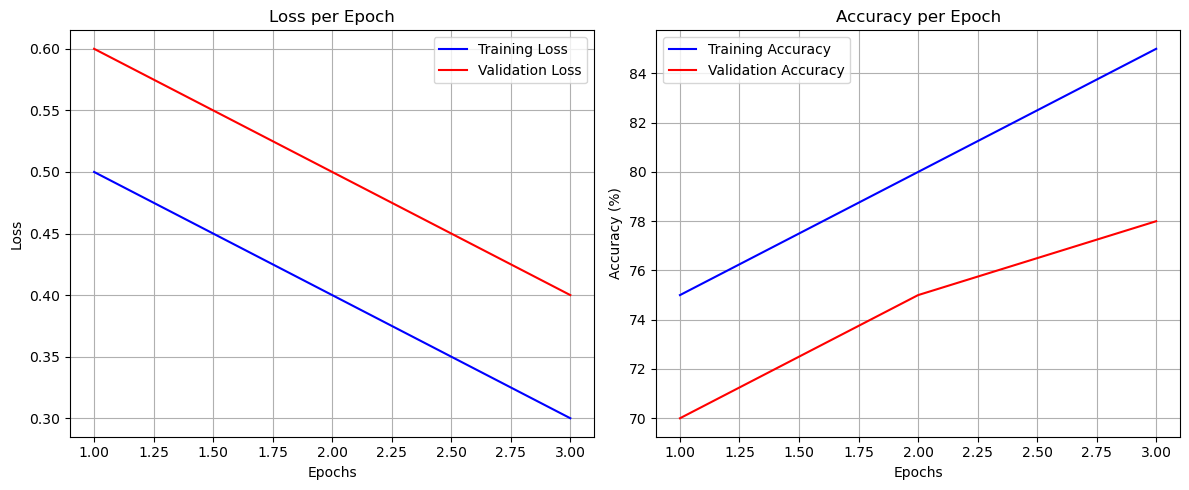

In [129]:
# Now visualize the history (loss and accuracy)
history_data = np.array([
    history['train_loss'],
    history['val_loss'],
    history['train_acc'],
    history['val_acc']
]).T  # Transpose to make it (epochs, metrics)

# Extract columns from the history_data array
train_loss = history_data[:, 0]
val_loss = history_data[:, 1]
train_acc = history_data[:, 2]
val_acc = history_data[:, 3]
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Test Image for testing ConvNext Model

In [287]:
import torch
from torchvision.models import convnext_tiny

# Define the ConvNeXt Tiny model with 9 output classes
model = convnext_tiny()
model.classifier[2] = torch.nn.Linear(in_features=768, out_features=9)

# Load the saved weights
state_dict = torch.load(r'C:\Users\DELL\ConvNeXt_model.pth')
model.load_state_dict(state_dict)

# Set to evaluation mode
model.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [101]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [288]:
test_image = Image.open(r'C:\Users\DELL\Downloads\test-image.jpg')

In [289]:
new_width = 224
new_height = 224  
resized_image = test_image.resize((new_width, new_height))

# save or display the resized image
resized_image.show()  

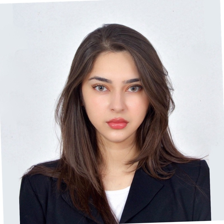

In [290]:
resized_image

In [291]:
# now, pre-process the image and prepare a batch so that it can pass through the network
img_l = transform(test_image)
batch_t = torch.unsqueeze(img_l, 0)

In [295]:
import torch.nn.functional as F

# Define age brackets
age_brackets = ['0-10', '10-19', '20-29', '30-39','40-49', '50-59', '60-69', '70-79', '80+']

with torch.no_grad():
    output = model(batch_t)
    probs = F.softmax(output, dim=1)

    # Predict gender using only class 0 and 1
    gender_probs = probs[:, :2]
    gender_idx = torch.argmax(gender_probs, dim=1).item()
    gender = "Male" if gender_idx == 0 else "Female"
    gender_confidence = gender_probs[0][gender_idx].item() * 100

    # Predict age using class 2 to 8
    age_probs = probs[:, 2:]
    age_idx = torch.argmax(age_probs, dim=1).item()
    age_display = age_brackets[age_idx]
    age_confidence = age_probs[0][age_idx].item() * 100

# Output
print(f"Predicted Gender: {gender}")
print(f"Gender Confidence: {gender_confidence:.2f}%")
print(f"Predicted Age: {age_display}")
print(f"Age Confidence: {age_confidence:.2f}%")


Predicted Gender: Female
Gender Confidence: 18.59%
Predicted Age: 50-59
Age Confidence: 23.00%


### 8. Streamlit app.py

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified VGG-16 model with two heads (age and gender)
class VGG16DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(VGG16DualHead, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Identity()  # Remove the existing classifier
        
        # Age head (classifier)
        self.age_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(512, num_age_classes)
        )
        
        # Gender head (classifier)
        self.gender_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(512, num_gender_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)
        features = features.view(features.size(0), -1)

        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)

        age_logits = torch.softmax(age_logits, dim=1)  # Apply softmax for age ranges

        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = VGG16DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)

# Save the state dict
torch.save(model.state_dict(), "vgg16_age_gender_state_dict.pth")
print("State dict saved as vgg16_age_gender_state_dict.pth")

# Define the checkpoint path
checkpoint_path = "vgg16_checkpoint.pth"

# Save the model, optimizer, and history
torch.save({
    'epoch': 5,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model saved successfully at {checkpoint_path}")

# Load the checkpoint
checkpoint = torch.load("vgg16_checkpoint.pth")

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
print(f"Model and optimizer loaded successfully from vgg16_checkpoint.pth")

# Make sure your model architecture is defined before loading
model = VGG16DualHead()  # Initialize your model class
model.load_state_dict(torch.load("vgg16_age_gender_state_dict.pth"))
model.eval()
print(type(history))
print(history)